## Splink data linking demo (link only)

In this demo we link two small datasets.  

The larger table contains duplicates, but in this notebook we use the `link_only` setting, so `splink` makes no attempt to deduplicate these records.    

Note it is possible to simultaneously link and dedupe using the `link_and_dedupe` setting.

**Important** Where deduplication is not required, `link_only` can provide an important performance boost by dramatically reducing the number of records which need to be compared.

For example, if you wanted to link 10 records to 1,000, then the maximum number of comparisons that need to be made (i.e. with no blocking rules) is 10,000.  If you need to dedupe as well, that number would be n(n-1)/2 = 509,545.



## Step 1:  Imports and setup

The following is just boilerplate code that sets up the Spark session and sets some other non-essential configuration options

In [1]:
import pandas as pd 
pd.options.display.max_columns = 500
pd.options.display.max_rows = 100
import altair as alt
alt.renderers.enable('mimetype')

RendererRegistry.enable('mimetype')

In [2]:
import logging 
logging.basicConfig()  # Means logs will print in Jupyter Lab

# Set to DEBUG if you want splink to log the SQL statements it's executing under the hood
logging.getLogger("splink").setLevel(logging.INFO)

In [3]:
from utility_functions.demo_utils import get_spark
spark = get_spark()

## Step 2: Read in the data

In this example, we link two datasets, but you can link as many as you like.

⚠️ Note that `splink` makes the following assumptions about your data:

-  There is a field containing a unique record identifier in each dataset.  By default, this should be called `unique_id`, but you can change this in the settings
-  There is a field containing a dataset name in each dataset, to disambiguate the `unique_id` column if the same id values occur in more than one dataset.  By default, this column is called `source_dataset`, but you can change this in the settings.
-  The two datasets being linked have common column names - e.g. date of birth is represented in both datasets in a field of the same name.   In many cases, this means that the user needs to rename columns prior to using `splink`


In [4]:
from pyspark.sql.functions import lit 
df_1 = spark.read.parquet("data/fake_df_l.parquet")
df_1 = df_1.withColumn("source_dataset", lit("df_1"))
df_2 = spark.read.parquet("data/fake_df_r.parquet")
df_2 = df_2.withColumn("source_dataset", lit("df_2"))
print(f"The count of rows in `df_1` is {df_1.count()}")
df_1.show(5)
print(f"The count of rows in `df_2` is {df_2.count()}")
df_2.show(5)

The count of rows in `df_1` is 181
+---------+----------+-------+----------+------------+--------------------+-----+--------------+
|unique_id|first_name|surname|       dob|        city|               email|group|source_dataset|
+---------+----------+-------+----------+------------+--------------------+-----+--------------+
|        0|    Julia |   null|2015-10-29|      London| hannah88@powers.com|    0|          df_1|
|        4|      oNah| Watson|2008-03-23|      Bolton|matthew78@ballard...|    1|          df_1|
|       13|    Molly |   Bell|2002-01-05|Peterborough|                null|    2|          df_1|
|       15| Alexander|Amelia |1983-05-19|     Glasgow|ic-mpbell@alleale...|    3|          df_1|
|       20|    Ol vri|ynnollC|1972-03-08|    Plymouth|derekwilliams@nor...|    4|          df_1|
+---------+----------+-------+----------+------------+--------------------+-----+--------------+
only showing top 5 rows

The count of rows in `df_2` is 819
+---------+----------+-------+--

## Step 3:  Configure splink using the `settings` object

Most of `splink` configuration options are stored in a settings dictionary.  This dictionary allows significant customisation, and can therefore get quite complex.  

💥 We provide an tool for helping to author valid settings dictionaries, which includes tooltips and autocomplete, which you can find [here](http://robinlinacre.com/splink_settings_editor/).

Customisation overrides default values built into splink.  For the purposes of this demo, we will specify a simple settings dictionary, which means we will be relying on these sensible defaults.

To help with authoring and validation of the settings dictionary, we have written a [json schema](https://json-schema.org/), which can be found [here](https://github.com/moj-analytical-services/splink/blob/master/splink/files/settings_jsonschema.json).  




In [5]:
# The comparison expression allows for the case where a first name and surname have been inverted 
sql_case_expression = """
CASE 
WHEN first_name_l = first_name_r AND surname_l = surname_r THEN 4 
WHEN first_name_l = surname_r AND surname_l = first_name_r THEN 3
WHEN first_name_l = first_name_r THEN 2
WHEN surname_l = surname_r THEN 1
ELSE 0 
END
"""

settings = {
    "link_type": "link_only", 
    "max_iterations": 20,
    "blocking_rules": [
    ],
    "comparison_columns": [
       {
            "custom_name": "name_inversion",
            "custom_columns_used": ["first_name", "surname"],
            "case_expression": sql_case_expression,
            "num_levels": 5
        },
        {
            "col_name": "city",
            "num_levels": 3
        },
        {
            "col_name": "email",
            "num_levels": 3
        },
        {
            "col_name": "dob"
        }
    ],
    "additional_columns_to_retain": ["group"],
    "em_convergence": 0.01,
    "max_iterations": 4,
}

In words, this setting dictionary says:

- We are performing a data linking task (the other options are `dedupe_only`, or `link_and_dedupe`)
- Since the input datasets are so small, we do not specify any blocking rules and instead generate all possible comparisons.
- When comparing records, we will use information from the `first_name`, `surname`, `city` and `email` columns to compute a match score.
- For the comparisons on the `first_name` and `surname` column we allow the possibility that the names have been inputted in the wrong order.  
  - The highest level of similarity is that both `first_name` and `surname` both match.
  - There are other levels of similarity for the names being inverted, and just first name, or just surname matching.
- We will retain the `group` column in the results even though this is not used as part of comparisons.  This is a labelled dataset and `group` contains the true match - i.e. where group matches, the records pertain to the same person

## Step 4:  Estimate match scores using the Expectation Maximisation algorithm

In [6]:
from splink import Splink

linker = Splink(settings, [df_1, df_2], spark)
df_e = linker.get_scored_comparisons()

# Later, we will make term frequency adjustments.  
# Persist caches these results in memory, preventing them having to be recomputed when we make these adjustments.
df_e.persist()  


/Users/robinlinacre/anaconda3/lib/python3.8/site-packages/splink/default_settings.py:187: UserWarning: You have not specified any blocking rules, meaning all comparisons between the input dataset(s) will be generated and blocking will not be used.For large input datasets, this will generally be computationally intractable because it will generate comparisons equal to the number of rows squared.
  warnings.warn(
INFO:splink.iterate:Iteration 0 complete
INFO:splink.model:The maximum change in parameters was 0.40458029469636825 for key name_inversion, level 4
INFO:splink.iterate:Iteration 1 complete
INFO:splink.model:The maximum change in parameters was 0.07434341748102571 for key email, level 1
INFO:splink.iterate:Iteration 2 complete
INFO:splink.model:The maximum change in parameters was 0.025150011310513642 for key dob, level 1
INFO:splink.iterate:Iteration 3 complete
INFO:splink.model:The maximum change in parameters was 0.009595088165527288 for key name_inversion, level 0
INFO:splink

DataFrame[match_weight: double, match_probability: double, source_dataset_l: string, unique_id_l: bigint, source_dataset_r: string, unique_id_r: bigint, first_name_l: string, first_name_r: string, surname_l: string, surname_r: string, gamma_name_inversion: int, city_l: string, city_r: string, gamma_city: int, email_l: string, email_r: string, gamma_email: int, dob_l: string, dob_r: string, gamma_dob: int, group_l: bigint, group_r: bigint]

## Step 5: Inspect results 



In [7]:
# Inspect main dataframe that contains the match scores
df_e.toPandas().sort_values("match_probability", ascending=False).head(20)

,match_weight,match_probability,source_dataset_l,unique_id_l,source_dataset_r,unique_id_r,first_name_l,first_name_r,surname_l,surname_r,gamma_name_inversion,city_l,city_r,gamma_city,email_l,email_r,gamma_email,dob_l,dob_r,gamma_dob,group_l,group_r
93101,37.816346,1.0,df_1,664,df_2,668,Ivy,Taylor,Taylor,Ivy,3,Lonon,London,1,jonesjennmfer@pitt.coi,jonesjennifer@pitts.com,1,1980-01-13,1980-01-13,1,113,113
93106,37.816346,1.0,df_1,664,df_2,673,Ivy,Taylor,Taylor,Ivy,3,Lonon,London,1,jonesjennmfer@pitt.coi,jonesjennifer@pitts.com,1,1980-01-13,1980-01-13,1,113,113
79930,37.816346,1.0,df_1,581,df_2,585,Eleanor,Shaw,Shaw,Eleanor,3,Birmingham,Birmingha,1,stephaniewebbhart.net,stephaniewebb@hart.net,1,1979-03-31,1979-03-31,1,97,97
73327,37.373057,1.0,df_1,517,df_2,526,Brown,Martha,Martha,Brown,3,Southend-on-Sea,Southend-on-Sea,2,watsonthomas@jones-stuart.biz,watsonthomas@jones-s.urttbiz,1,2002-09-01,2002-09-01,1,89,89
79105,37.373057,1.0,df_1,574,df_2,578,George,Williams,Williams,George,3,London,London,2,desek58gibbr.biz,derek58@gibbs.biz,1,1981-08-06,1981-08-06,1,96,96
73322,37.373057,1.0,df_1,517,df_2,521,Brown,Martha,Martha,Brown,3,Southend-on-Sea,Southend-on-Sea,2,watsonthomas@jones-stuart.biz,watsonthomas@onesistuart.b-z,1,2002-09-01,2002-09-01,1,89,89
29657,37.373057,1.0,df_1,209,df_2,210,Thompson,Freddie,Freddie,Thompson,3,Peterborough,Peterborough,2,scottsalinas@hughes-lopez.com,scottsalinah@ughes-lopez.com,1,1999-07-23,1999-07-23,1,36,36
142479,37.373057,1.0,df_1,960,df_2,966,Gabriel,Bartlett,Bartlett,Gabriel,3,Wolverhampton,Wolverhampton,2,ogomez@robinson-mckinney.com,ogomez@rob-nsonimcknney.com,1,1973-12-09,1973-12-09,1,173,173
79104,37.373057,1.0,df_1,574,df_2,577,George,Williams,Williams,George,3,London,London,2,desek58gibbr.biz,derek58@gibbs.biz,1,1981-08-06,1981-08-06,1,96,96
102976,37.373057,1.0,df_1,726,df_2,727,Harry,Lawrence,Lawrence,Harry,3,Stoke-on-Trent,Stoke-on-Trent,2,aarbarpace@mbnning.org,barbarapace@manning.org,1,2016-12-25,2016-12-25,1,125,125


The `params` property of the `linker` is an object that contains a lot of diagnostic information about how the match probability was computed.  The following cells demonstrate some of its functionality

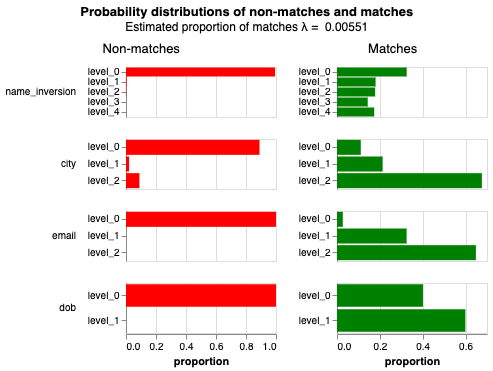

In [8]:
model = linker.model
model.probability_distribution_chart()

An alternative representation of the parameters displays them in terms of the effect different values in the comparison vectors have on the match probability:

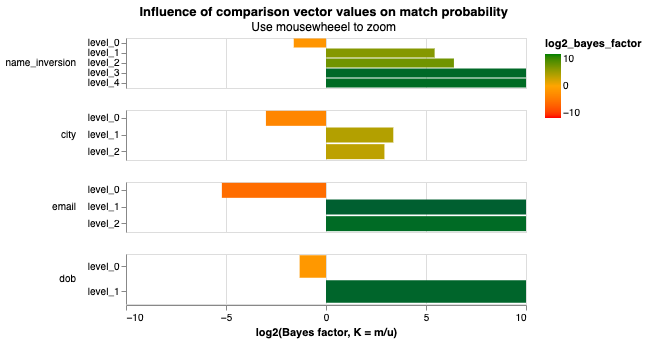

In [9]:
model.bayes_factor_chart()

In [10]:
# If charts aren't displaying correctly in your notebook, you can write them to a file (by default splink_charts.html)
model.all_charts_write_html_file("splink_charts.html", overwrite=True)

You can also generate a report which explains how the match probability was computed for an individual comparison row.  

Note that you need to convert the row to a dictionary for this to work

In [11]:
from splink.intuition import intuition_report
row_dict = df_e.toPandas().sample(1).to_dict(orient="records")[0]
print(intuition_report(row_dict, model))


Initial probability of match (prior) = λ = 0.005509
------
Comparison of name_inversion.  Values are:         
name_inversion_l:                                  Charlotte , None
name_inversion_r:                                  Amelia , Johnson
Comparison has:                                    5 levels
Level for this comparison:                         gamma_name_inversion = 0
m probability = P(level|match):                    0.3251
u probability = P(level|non-match):                0.9937
Bayes factor = m/u:                                0.3272
New probability of match (updated belief):         0.001809

------
Comparison of city.  Values are:                   
city_l:                                            Sunderland
city_r:                                            Luton
Comparison has:                                    3 levels
Level for this comparison:                         gamma_city = 0
m probability = P(level|match):                    0.111
u probability = P(le

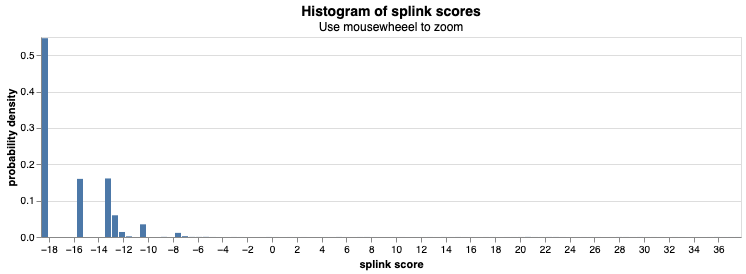

In [12]:
from splink.diagnostics import splink_score_histogram
splink_score_histogram(df_e, spark, 100, "match_weight", symmetric=False)